In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import os

In [2]:
def get_data(dates):
    df = pd.DataFrame(index=dates)
    df_temp = pd.read_csv('AAPL_stock_data_year.csv', index_col='Date', parse_dates=True, usecols=['Date','High','Low','Close','Volume'], na_values=['nan'])
    df = df.join(df_temp)
    df['Volume'] = df['Volume'].replace(',', '', regex=True)
    df = df.astype({'High':'float','Close':'float','Volume':'float'})
    return df

def get_stock_price(dates):
    df = pd.DataFrame(index=dates)
    df_temp = pd.read_csv('AAPL_stock_data_year.csv', index_col='Date', parse_dates=True, usecols=['Date','Close'], na_values=['nan'])
    df = df.join(df_temp)
    df['Volume'] = df['Volume'].replace(',', '', regex=True)
    df = df.astype({'Close':'float'})
    return df


In [3]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

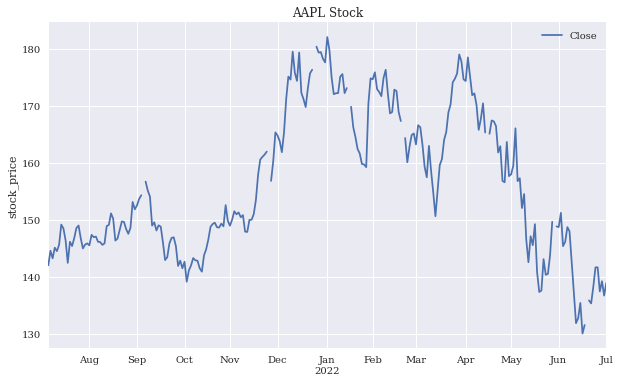

In [5]:
dates = pd.date_range('07/06/2021', '07/01/2022', freq='B')
df = get_data(dates)
df.fillna(method='pad')
df[['Close']].plot(figsize=(10,6), subplots=True)
plt.ylabel("stock_price")
plt.title("AAPL Stock")
plt.show()

In [6]:
df = df[['Close']]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 2021-07-06 to 2022-07-01
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   251 non-null    float64
dtypes: float64(1)
memory usage: 12.1 KB


In [7]:
df = df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1,1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [8]:
look_back = 100
x_train, y_train, x_test, y_test = load_data(df, look_back = look_back)
print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_test.shape = {x_test.shape}')
print(f'y_test.shape = {y_test.shape}')

x_train.shape = (127, 99, 1)
y_train.shape = (127, 1)
x_test.shape = (32, 99, 1)
y_test.shape = (32, 1)


In [9]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
y_train.size(), x_train.size()

(torch.Size([127, 1]), torch.Size([127, 99, 1]))

In [11]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [12]:
num_epochs = 100
hist = np.zeros(num_epochs)

seq_dim = look_back-1

for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} MSE: {loss.item()}')

    hist[epoch] = loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

Epoch: 0 MSE: 0.29276198148727417


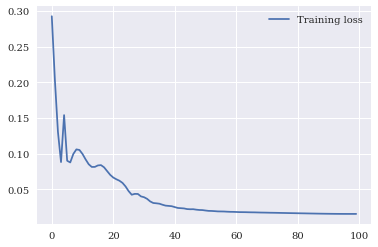

In [13]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [14]:
np.shape(y_train_pred)

torch.Size([127, 1])

In [15]:
y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

Train Score: 3.26 RMSE
Test Score: 5.86 RMSE


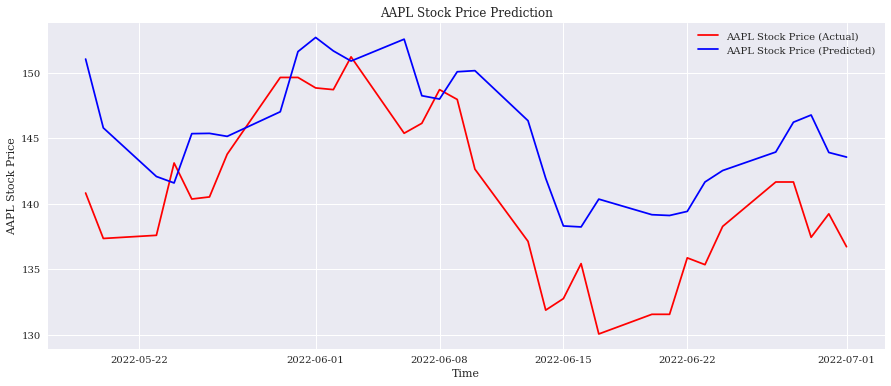

In [16]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color='red', label = 'AAPL Stock Price (Actual)')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color='blue', label = 'AAPL Stock Price (Predicted)')

plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()